In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os


In [2]:
path = 'data/'
files = os.listdir(path)
# Solo se retienen archivos nc
dict_files = {
    'date':list(),
    'link':list()
}

for file in files:
    if '.nc' in file:
        # generacion link
        link = os.path.join(
            path,
            file
        )
        #Formateo fecha
        year = file.split('_')[2]
        month = file.split('_')[3].split('.')[0]
        date = pd.to_datetime(year + '/' + month)
        # Almacenamiento
        dict_files['date'].append(date)
        dict_files['link'].append(link)
# Creacion del dataframe
df_files = pd.DataFrame(dict_files)
df_files.set_index(
    'date',
    drop=True,
    inplace=True
)
df_files = df_files.sort_index()

In [63]:
def get_all_data():
    combined = xr.open_dataset(df_files['link'][0])
    for i,link in enumerate(df_files['link'].to_numpy()):
        # print(f'processing {link}')
        temporal = xr.open_dataset(link)
        combined = xr.concat([combined,temporal],dim = "valid_time")
    return combined.to_dataframe()

def get_data_by_coordenates(lat,long):
    combined = xr.open_dataset(df_files['link'][0]).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

    )
    for i,link in enumerate(df_files['link'][1:].to_numpy()):
        # print(f'processing {link}')
        temporal = xr.open_dataset(link).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

        )
        combined = xr.concat([combined,temporal],dim = "valid_time")
    return combined.to_dataframe()

def get_data_by_coordenates_date(lat,long,start,end):
    # se entregan los datos de fecha con el formato "1990-01-30"

    df_filtered = df_files[(df_files.index>=start) & (df_files.index<end)]
    
    acum = xr.open_dataset(df_filtered['link'][0]).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

    )
    for i,link in enumerate(df_filtered[(df_filtered.index>=start) & (df_filtered.index<end)]['link'][1:].to_numpy()):
        # print(f'processing {link}')
        temporal = xr.open_dataset(link).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

        )
        acum = xr.concat([acum,temporal],dim = "valid_time")
    return acum.to_dataframe()


In [121]:
x_training = get_data_by_coordenates_date(6.0, -75.0,'2009','2010')
y_training = get_data_by_coordenates_date(6.0, -75.5,'2009','2010')

/tmp/ipykernel_44830/3433687123.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acum = xr.open_dataset(df_filtered['link'][0]).sel(
/tmp/ipykernel_44830/3433687123.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acum = xr.open_dataset(df_filtered['link'][0]).sel(


In [122]:
x_training = np.sqrt(x_training['u10']*x_training['u10'] + x_training['v10']*x_training['v10'] )
y_training = np.sqrt(y_training['u10']*y_training['u10'] + y_training['v10']*y_training['v10'] )

In [123]:
np.corrcoef(x_training,y_training)[0][1]

np.float64(0.06811230026014828)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


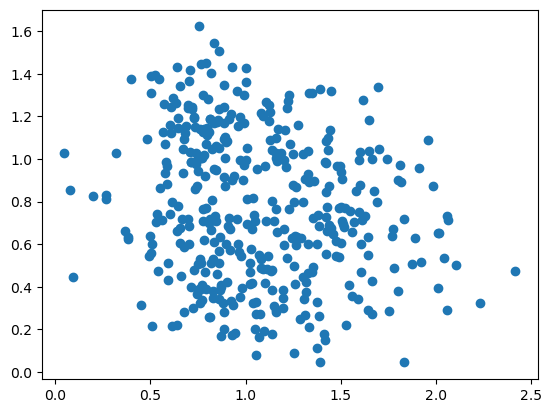

In [157]:
import matplotlib.pyplot as plt
plt.scatter(x_training[200:600],y_training[200:600])